# Loading Dataset And Dependencies

In [1]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# loading data
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df_data = pd.concat([df_train, df_test], ignore_index=True)  # Concatenate train and test datasets

# Introduce New Features

In [3]:
# Encode sex
df_data['Sex_Code'] = df_data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')


In [4]:
# Fill in missing fare values
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())

# Making Bins
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)

label = LabelEncoder()
df_data['FareBin_Code_5'] = label.fit_transform(df_data['FareBin_5'])

In [5]:
"""
Another way of binning, by clustering, incoporating the deck information
"""
def get_deck(cabin):
    if pd.isna(cabin):
        return 'Unknown'
    else:
        return cabin[0]

def deck_mapping(deck):
    deck_mapping_dict = {'Unknown': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
    return deck_mapping_dict.get(deck, 0)

df_data['Deck'] = df_data['Cabin'].apply(get_deck)
df_data['Deck_encode'] = df_data['Deck'].apply(deck_mapping)

df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())
fare_weight = 0.05
df_data['Fare_Scaled'] = df_data['Fare'] * fare_weight

features_for_clustering = df_data[['Fare_Scaled', 'Deck_encode']]

kmeans = KMeans(n_clusters=5, random_state=0)
df_data['FareDeck_5'] = kmeans.fit_predict(features_for_clustering)

label = LabelEncoder()
df_data['FareDeck_Code_5'] = label.fit_transform(df_data['FareDeck_5'])

c:\Users\jj186\anaconda3\envs\3.8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


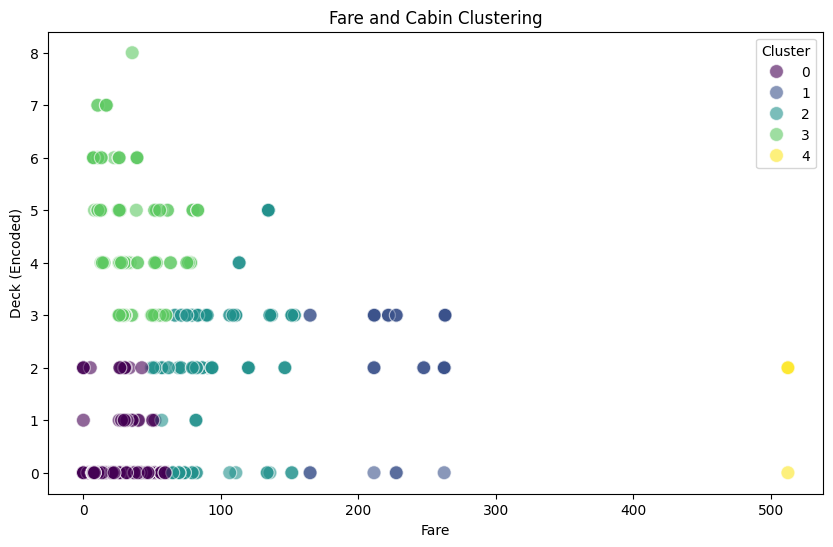

In [6]:
# visualize the clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Fare', y='Deck_encode', hue='FareDeck_5', palette='viridis', data=df_data, s=100, alpha=0.6, edgecolor='w')
plt.title('Fare and Cabin Clustering')
plt.xlabel('Fare')
plt.ylabel('Deck (Encoded)')
plt.legend(title='Cluster')
plt.show()

In [7]:
# Family_size
df_data['Family_size'] = df_data['SibSp'] + df_data['Parch'] + 1

# how about the fare values of deplicate tickets 
deplicate_ticket = []
for tk in df_data.Ticket.unique():
    tem = df_data.loc[df_data.Ticket == tk, 'Fare']
    if tem.count() > 1:
        deplicate_ticket.append(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)

In [8]:
# feature found out in [Blood is thicker than water & friendship forever](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever/code) by S.Xu. 
df_data['Connected_Survival'] = 0.5 # default 
for _, df_grp in df_data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 0

In [9]:
"""
one way of filling in missing age values
"""
# extracted title using name
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'],'Mrs')
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })
Ti_pred = df_data.groupby('Title')['Age'].median().values
df_data['Ti_Age'] = df_data['Age']
# Filling the missing age
for i in range(0,5):
    df_data.loc[(df_data.Age.isnull()) & (df_data.Title == i),'Ti_Age'] = Ti_pred[i]
df_data['Ti_Age'] = df_data['Ti_Age'].astype('int')

# extract minor
df_data['Age_copy'] = df_data['Age'].fillna(-1)
df_data['Minor'] = (df_data['Age_copy'] < 14.0) & (df_data['Age_copy']>= 0)
df_data['Minor'] = df_data['Minor'] * 1
# We could capture more 8 Master in Pclass = 3 by filling missing age 
df_data['Ti_Minor'] = ((df_data['Ti_Age']) < 14.0) * 1

In [10]:
"""
one way of filling in missing age values, by imputing
"""
from sklearn.ensemble import RandomForestRegressor

def random_forest_impute(df):
    known_age = df[df['New_Age'].notnull()]
    unknown_age = df[df['New_Age'].isnull()]
    
    X_train = known_age[['Pclass', 'Title']]
    y_train = known_age['New_Age']
    X_test = unknown_age[['Pclass', 'Title']]
    
    rfr = RandomForestRegressor(random_state=0, n_estimators=100)
    rfr.fit(X_train, y_train)
    
    predicted_ages = rfr.predict(X_test)
    df.loc[df['New_Age'].isnull(), 'New_Age'] = predicted_ages
    
    return df

impute_function = random_forest_impute
df_data['New_Age'] = df_data['Age']
df_data = impute_function(df_data)

df_data['Age_Group'] = pd.cut(df_data['New_Age'], bins=[0, 14, 60, 100], labels=['0', '1', '2']) # ['Child', 'Adult', 'Senior']

# Training Models

## 1. Find Best Hyper-parameter by Grid search

In [11]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, cross_val_score
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import classification_report

# # df_data = ...
# # df_train = df_data[:len(df_train)]
# # df_test = df_data[len(df_train):]

# df_train = df_data[:len(df_train)]
# df_test = df_data[len(df_train):]

# X_train = df_train.drop(labels=['Survived', 'PassengerId'], axis=1)
# Y_train = df_train['Survived']
# X_test = df_test.drop(labels=['Survived', 'PassengerId'], axis=1)
# Y_test = df_test['Survived']

# print(X_train.columns)

# minor_features = ['Sex_Code', 'Pclass', 'FareBin_Code_5', 'Connected_Survival', 'Ti_Minor']

# clf = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)

# param_grid = {
#     'clf__n_estimators': [100, 250, 500],
#     'clf__min_samples_split': [2, 10, 20],
#     'clf__max_depth': [None, 10, 20, 30]
# }

# pipeline = Pipeline([('clf', clf)])

# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=2)

# grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=3, scoring='accuracy', cv=cv)
# grid_search.fit(X_train[minor_features], Y_train)

# print("Best score: %0.3f" % grid_search.best_score_)
# print(grid_search.best_estimator_)

# # report(grid_search.cv_results_)  # 这里假设您有一个report函数来打印结果

# print('-----grid search end------------')

# X_Submit = df_test.drop(labels=['PassengerId'], axis=1)
# best_model = grid_search.best_estimator_
# predictions = best_model.predict(X_Submit[minor_features])

# submit = pd.DataFrame({"PassengerId": df_test['PassengerId'], "Survived": predictions.astype(int)})
# submit.to_csv("submit_best_model.csv", index=False)

## 2. Random Forrest with fare bin & median age 

In [12]:
# # splits again beacuse we just engineered new feature
# df_train = df_data[:len(df_train)]
# df_test = df_data[len(df_train):]
# # Training set and labels
# X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
# Y = df_train['Survived']
# # Show columns
# X.columns

# minor = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival','Ti_Minor']
# minor_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
# minor_Model.fit(X[minor], Y)
# print('Minor oob score :%.5f' %(minor_Model.oob_score_),'   LB_Public : 0.82296')

## 3. Random Forrest with fare clustering & age imputing 

In [13]:
# # splits again beacuse we just engineered new feature
# df_train = df_data[:len(df_train)]
# df_test = df_data[len(df_train):]
# # Training set and labels
# X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
# Y = df_train['Survived']
# # Show columns
# X.columns

# minor = ['Sex_Code','Pclass','FareDeck_Code_5','Connected_Survival','Age_Group']
# minor_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
# minor_Model.fit(X[minor], Y)
# print('Minor oob score :%.5f' %(minor_Model.oob_score_),'   LB_Public : 0.82296')

## 4. Plot Learning Curve

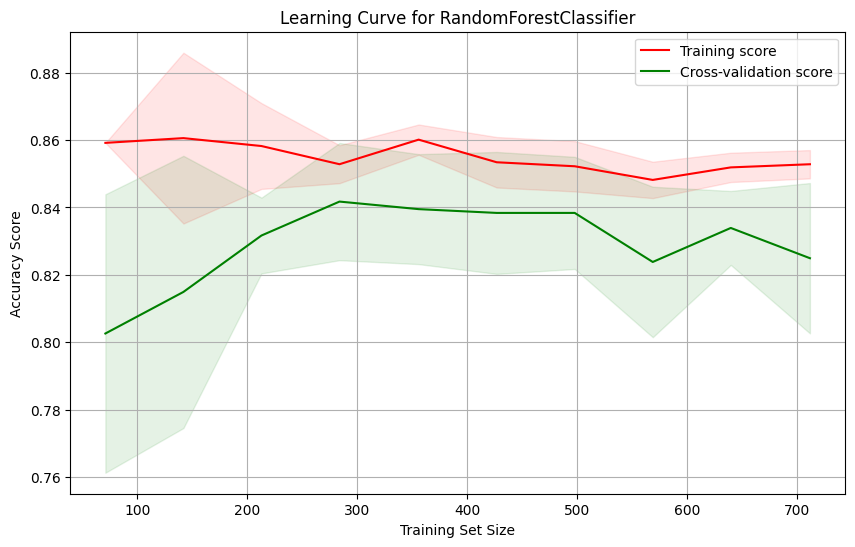

Minor oob score : 0.84400    LB_Public : 0.82296


In [14]:
from sklearn.model_selection import learning_curve
import numpy as np

# 再次分割数据集
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

# 训练集和标签
X = df_train.drop(labels=['Survived', 'PassengerId'], axis=1)
Y = df_train['Survived']

# 特征选择
minor = ['Sex_Code', 'Pclass', 'FareBin_Code_5', 'Connected_Survival', 'Ti_Minor']

# 定义模型
minor_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)

# 绘制学习曲线
train_sizes, train_scores, valid_scores = learning_curve(minor_Model, X[minor], Y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# 计算训练和验证分数的均值和标准差
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# 绘制学习曲线
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='r')
plt.plot(train_sizes, valid_scores_mean, label='Cross-validation score', color='g')

# 填充区域
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color='g')

# 图表信息
plt.title('Learning Curve for RandomForestClassifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# 输出OOB分数
minor_Model.fit(X[minor], Y)
print('Minor oob score : %.5f' % minor_Model.oob_score_, '   LB_Public : 0.82296')

## 5. Submit

In [15]:
# X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

# minor_pred = minor_Model.predict(X_Submit[minor])

# submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
#                       "Survived":minor_pred.astype(int)})
# submit.to_csv("submit_minor.csv",index=False)